# Parallel calculations of transforms

Scikit-mol supports parallel calculations of fingerprints and descriptors. This feature can be activated and configured using the `n_jobs` parameter or the `.n_jobs` attribute after object instantiation.

To begin, let's import the necessary libraries: RDKit and pandas. And of course, we'll also need to import scikit-mol, which is the new kid on the block.

In [1]:
import pathlib
import time

import pandas as pd
from rdkit.Chem import PandasTools

from scikit_mol.conversions import SmilesToMolTransformer
from scikit_mol.descriptors import MolecularDescriptorTransformer
from scikit_mol.fingerprints import MorganFingerprintTransformer

## Obtaining the Data

We'll need some data to work with, so we'll use a dataset of SLC6A4 active compounds from ExcapeDB that is available on Zenodo. Scikit-mol uses a subset of this dataset for testing purposes, and the samples have been specially selected to provide good results in testing. Note: This dataset should never be used for production modeling.

In the code below, you can set full_set to True to download the full dataset. Otherwise, the smaller dataset will be used.

In [2]:
full_set = False

if full_set:
    csv_file = "SLC6A4_active_excape_export.csv"
    if not pathlib.Path(csv_file).exists():
        import urllib.request

        url = "https://ndownloader.figshare.com/files/25747817"
        urllib.request.urlretrieve(url, csv_file)
else:
    csv_file = "../tests/data/SLC6A4_active_excapedb_subset.csv"

In [3]:
data = pd.read_csv(csv_file)

PandasTools.AddMoleculeColumnToFrame(data, smilesCol="SMILES")
print(f"{data.ROMol.isna().sum()} out of {len(data)} SMILES failed in conversion")

0 out of 200 SMILES failed in conversion


## Evaluating the Impact of Parallelism on Transformations

Let's start by creating a baseline for our calculations without using parallelism.

In [4]:
transformer = MolecularDescriptorTransformer(n_jobs=1)

In [6]:
def test_transformer(transformer):
    t0 = time.time()
    X = transformer.transform(data.ROMol)
    t = time.time() - t0
    print(
        f"Calculation time on dataset of size {len(data)}  with n_jobs={transformer.n_jobs}:\t{t:0.2F} seconds"
    )


test_transformer(transformer)

/home/anton/scikit-mol/.venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Calculation time on dataset of size 200  with parallel=1:	2.10 seconds



Let's see if parallelism can help us speed up our transformations.

In [8]:
transformer = MolecularDescriptorTransformer(n_jobs=2)
test_transformer(transformer)

/home/anton/scikit-mol/.venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Calculation time on dataset of size 200  with parallel=2:	2.19 seconds


We've seen that parallelism can help speed up our transformations, with the degree of speedup depending on the number of CPU cores available. However, it's worth noting that there may be some overhead associated with the process of splitting the dataset, pickling objects and functions, and passing them to the parallel child processes. As a result, it may not always be worthwhile to use parallelism, particularly for smaller datasets or certain types of fingerprints.

It's also worth noting that there are different methods for creating the child processes, with the default method on Linux being 'fork', while on Mac and Windows it's 'spawn'. The code we're using has been tested on Linux using the 'fork' method.

Now, let's see how parallelism impacts another type of transformer.

In [11]:
transformer = MorganFingerprintTransformer(n_jobs=1)
test_transformer(transformer)
transformer.n_jobs = 2
test_transformer(transformer)

Calculation time on dataset of size 200  with parallel=1:	0.03 seconds
Calculation time on dataset of size 200  with parallel=2:	0.08 seconds


Interestingly, we observed that parallelism actually took longer to calculate the fingerprints in some cases, which is a perfect illustration of the overhead issue associated with parallelism. Generally, the faster the fingerprint calculation in itself, the larger the dataset needs to be for parallelism to be worthwhile. For example, the Descriptor transformer, which is one of the slowest, can benefit even for smaller datasets, while for faster fingerprint types like Morgan, Atompairs, and Topological Torsion fingerprints, the dataset needs to be larger.

![ Relation ship between throughput and parallel speedup](https://github.com/EBjerrum/scikit-mol/raw/main/notebooks/images/max_speedup_vs_throughput.png "Not all fingerprints are equally fast and benefit the same from parallelism")

We've also included a series of plots below, showing the speedup over serial for different numbers of cores used for different dataset sizes. These timings were taken on a 16 core machine (32 Hyperthreads). Only the largest datasets (>10,000 samples) would make it worthwhile to parallelize Morgan, Atompairs, and Topological Torsions. SECfingerprint, MACCS keys, and RDKitFP are intermediate and would benefit from parallelism when the dataset size is larger, say >500. Descriptors, on the other hand, benefit almost immediately even for the smallest datasets (>100 samples).

![Atompairs fingerprint](https://github.com/EBjerrum/scikit-mol/raw/main/notebooks/images/AtomPairFingerprintTransformer_par.png "Atompairs fingerprint speedup")

![Descriptors calculation speedup](https://github.com/EBjerrum/scikit-mol/raw/main/notebooks/images/Desc2DTransformer_par.png "Descriptors calculation speedup")

![MACCS keys speedup](https://github.com/EBjerrum/scikit-mol/raw/main/notebooks/images/MACCSTransformer_par.png "MACCS keys speedup")

![Morgan fingerprint speedup](https://github.com/EBjerrum/scikit-mol/raw/main/notebooks/images/MorganTransformer_par.png "Morgan fingerprint speedup")

![RDKit fingerprint speedup](https://github.com/EBjerrum/scikit-mol/raw/main/notebooks/images/RDKitFPTransformer_par.png "RDKit fingerprint speedup")

![SEC fingerprint speedup](https://github.com/EBjerrum/scikit-mol/raw/main/notebooks/images/SECFingerprintTransformer_par.png "SEC fingerprint speedup")

![TopologicalTorsion fingerprint speedup](https://github.com/EBjerrum/scikit-mol/raw/main/notebooks/images/TopologicalTorsionFingerprintTransformer_par.png "TopologicalTorsion fingerprint speedup")





## Performance heatmaps

Multiprocessing performance is highly dependent on CPU performance, type of the function and the size of the dataset. To help users understand the performance of their system, we have created a series of heatmaps showing the speedup of different transformers for different dataset sizes and number of cores. The heatmaps are based on the same data as the plots above.
If you what to test the performance of your system, you can run the code below.

In [12]:
from rdkit import Chem

from scikit_mol.fingerprints import (
    AtomPairFingerprintTransformer,
    AvalonFingerprintTransformer,
    MHFingerprintTransformer,
    MorganFingerprintTransformer,
    RDKitFingerprintTransformer,
    TopologicalTorsionFingerprintTransformer,
)
from scikit_mol.plotting import ParallelTester, plot_heatmap
from scikit_mol.standardizer import Standardizer

mols = [Chem.MolFromSmiles("CCCCCCCCBr")] * 100000
transformers = [
    Standardizer(),
    MorganFingerprintTransformer(),
    MolecularDescriptorTransformer(),
    MHFingerprintTransformer(),
    AtomPairFingerprintTransformer(),
    AvalonFingerprintTransformer(),
    RDKitFingerprintTransformer(),
    TopologicalTorsionFingerprintTransformer(),
]

`ParallelTester` accept the following parameters:
- `transformer` - the transformer to test
- `mols` - the dataset to test
- `n_mols` - the number of molecules to test on  (the largest number should be less than or equal to the number of molecules in `mols`)
- `n_cores` - the number of cores to test on (the largest number should be less than or equal to the number of cores in your system) 
- `backend` - the backend to use for multiprocessing (default is `loky`, see [joblib documentation](https://joblib.readthedocs.io/en/latest/parallel.html) for more options)

In [13]:
transformer = MorganFingerprintTransformer()
df = ParallelTester(transformer, mols).test()
df

,10,100,100,1000,10000,100000
1,0.002394,0.003997,0.003997,0.031515,0.479826,3.228737
2,0.012707,1.278691,1.278691,1.246285,1.507089,3.614131
4,1.238397,1.330802,1.330802,1.20337,1.389253,2.891467
8,1.657188,1.669887,1.669887,1.601371,1.635777,2.541485


Resulting df have one row for each `n_jobs` and one row for each `n_mols`. Results can be plotted as a heatmap using the `plot_heatmap` method.

<Axes: title={'center': 'Morgan Fingerprint\nMax single-threaded speed 31731 mols/s\nCPU: AMD Ryzen 9 4900HS with Radeon Graphics'}, xlabel='Number of mols', ylabel='Number of jobs'>

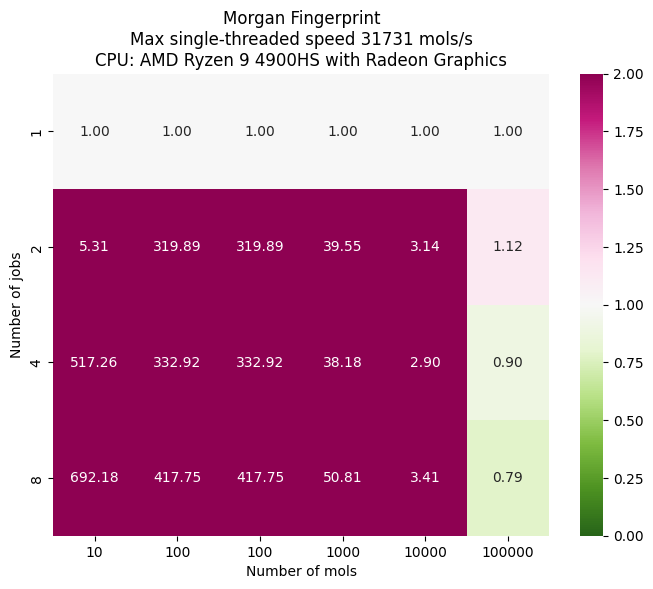

In [14]:
plot_heatmap(df, "Morgan Fingerprint")

By default the time is normalized to the time of the serial calculation. Such as a value of 2 means that the calculation took twice as long as the serial calculation and values below 1 means that the calculation was faster than the serial calculation.
If you want to see the absolute time, you can set `normalize=False`.

<Axes: title={'center': 'Morgan Fingerprint\nMax single-threaded speed 31731 mols/s\nCPU: AMD Ryzen 9 4900HS with Radeon Graphics'}, xlabel='Number of mols', ylabel='Number of jobs'>

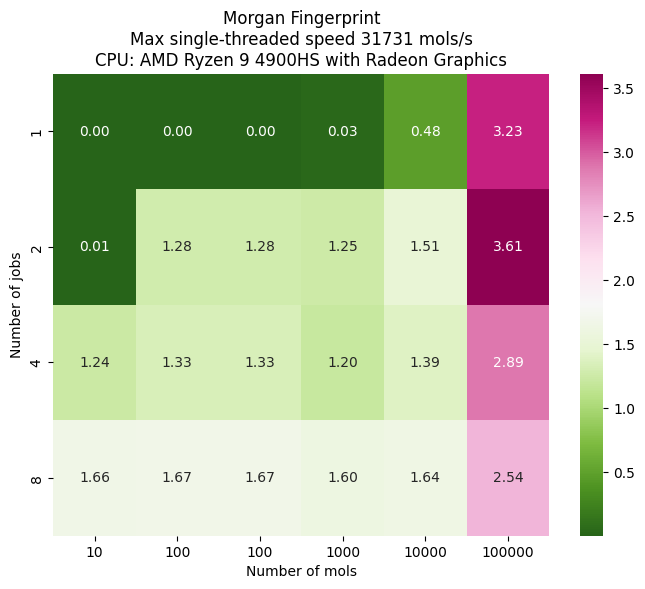

In [15]:
plot_heatmap(df, "Morgan Fingerprint", normalize=False)

Below is example heatmaps for the native `scikit-mol` transformers.

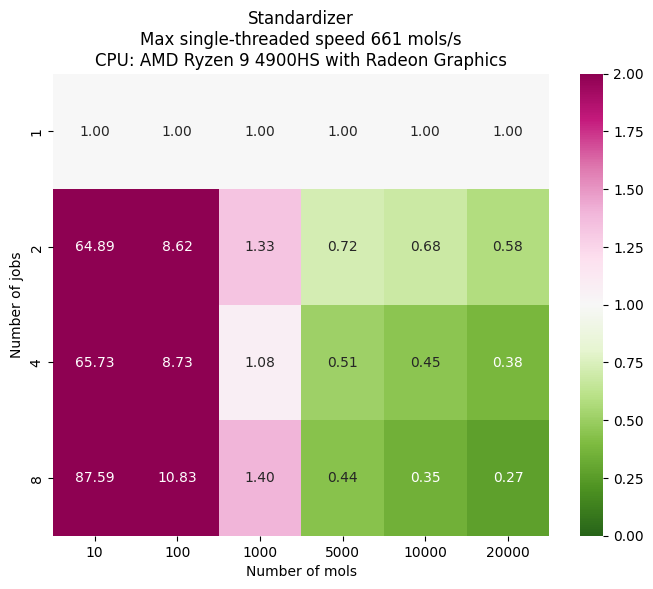

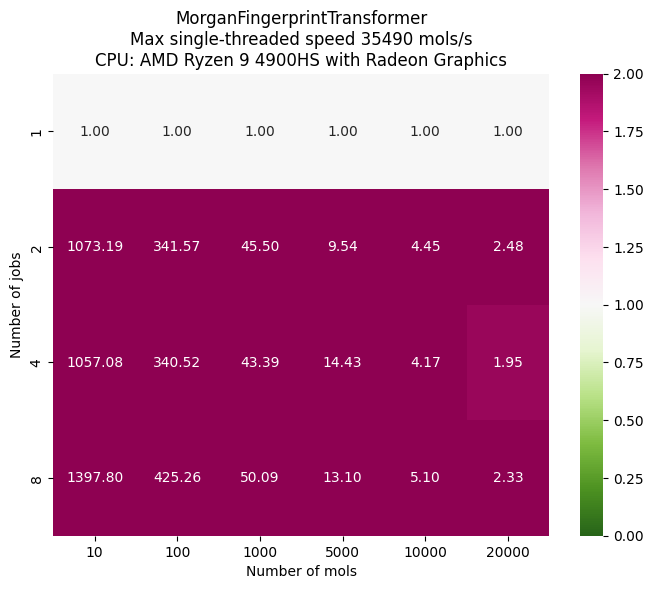

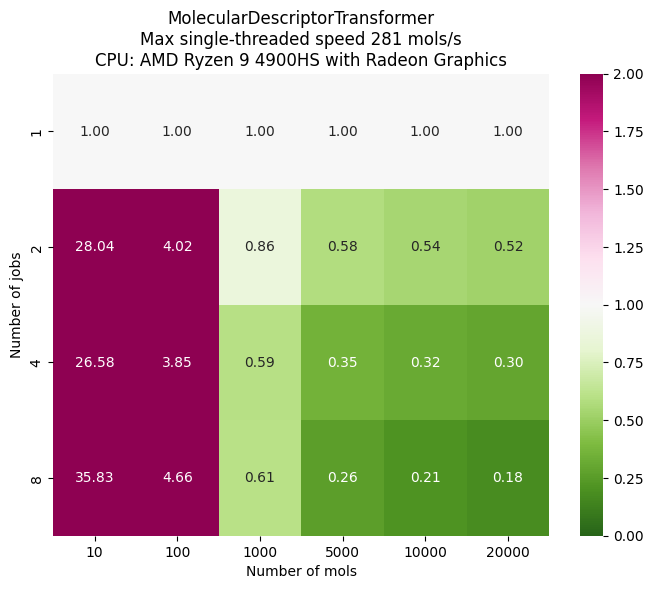

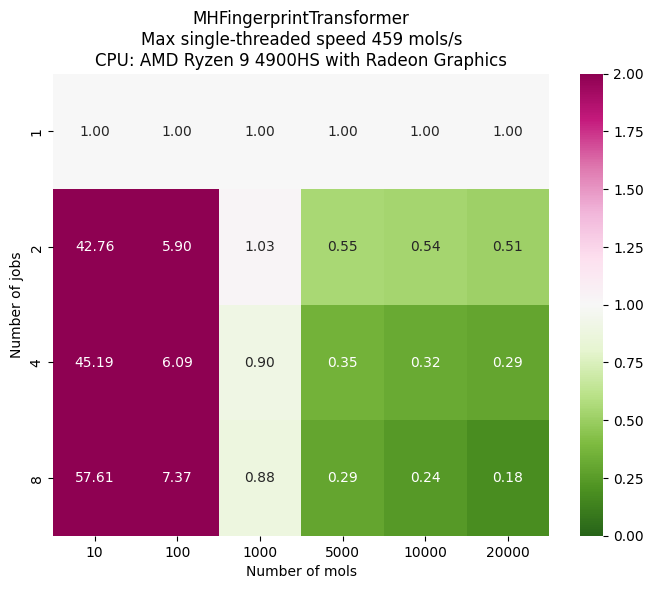

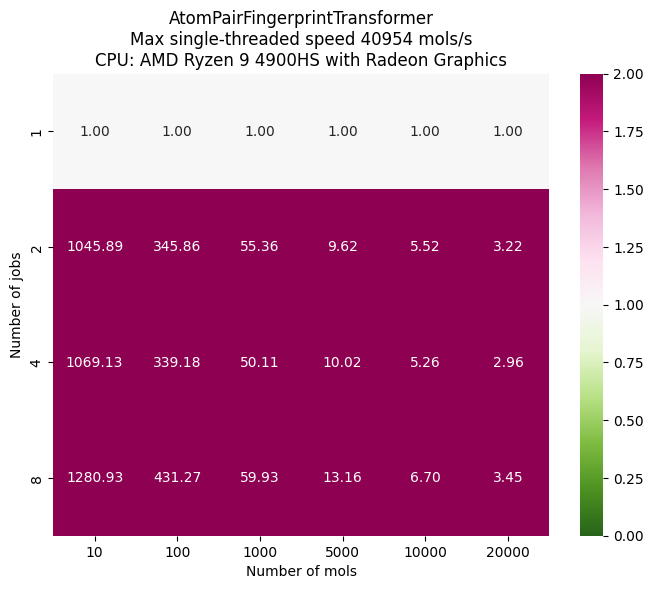

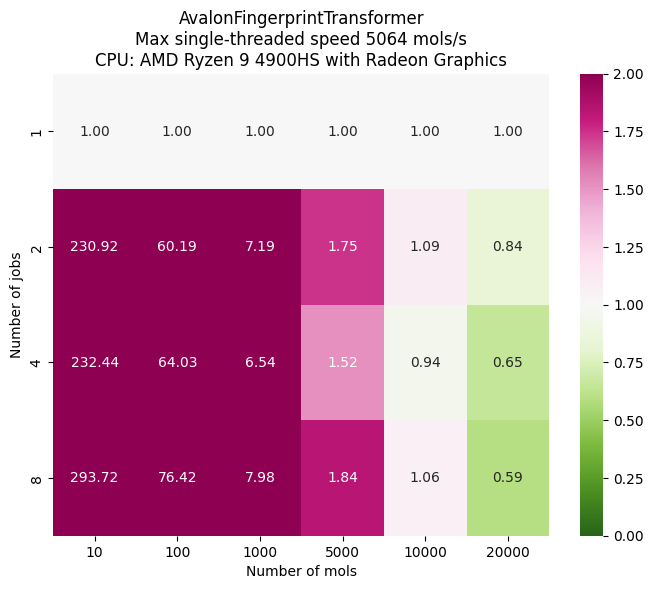

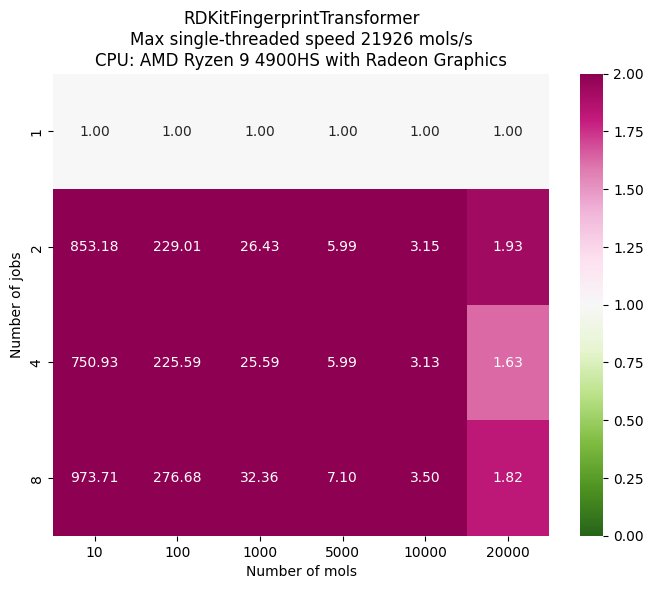

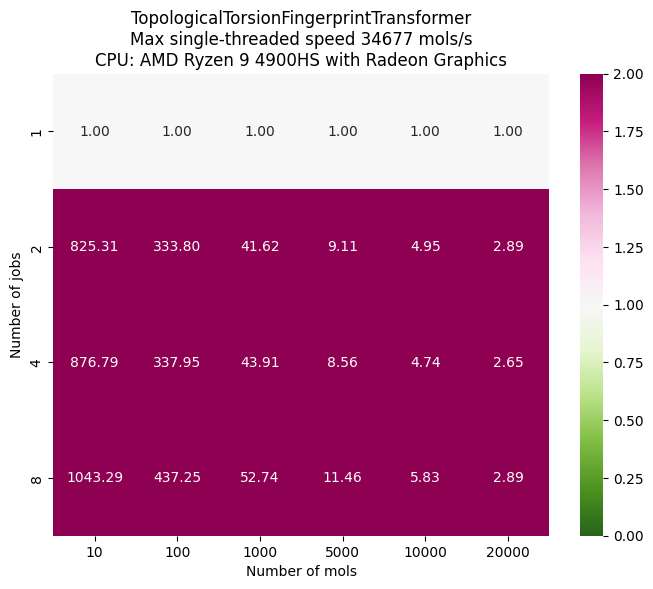

In [16]:
for transformer in transformers:
    tester = ParallelTester(
        transformer,
        mols,
        n_mols=[10, 100, 1000, 5000, 10000, 20000],
        n_jobs=[1, 2, 4, 8],
    )
    results = tester.test()
    plot_heatmap(results, transformer.__class__.__name__)

<Axes: title={'center': 'SMILES to Mol\nMax single-threaded speed 26505 mols/s\nCPU: AMD Ryzen 9 4900HS with Radeon Graphics'}, xlabel='Number of mols', ylabel='Number of jobs'>

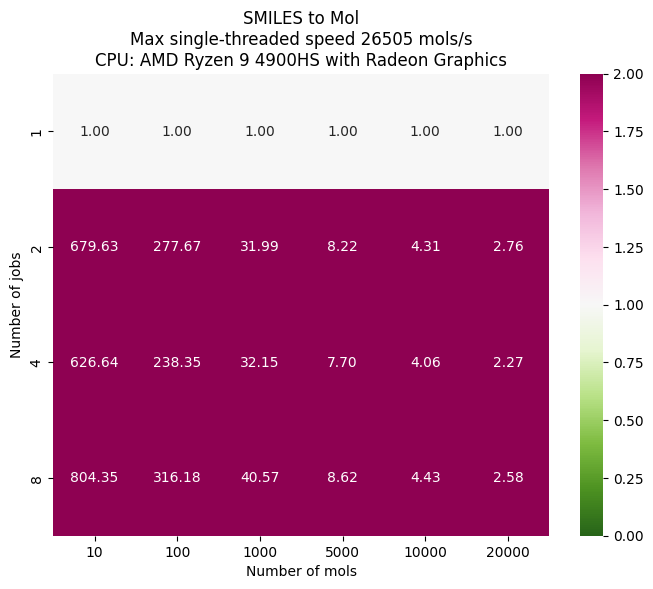

In [17]:
smiles = ["CCCCCCCCBr"] * 100000
transformer = SmilesToMolTransformer()
df = ParallelTester(
    transformer, smiles, n_mols=[10, 100, 1000, 5000, 10000, 20000], n_jobs=[1, 2, 4, 8]
).test()
plot_heatmap(df, "SMILES to Mol")

## Modifing multiprocessing backend

We use `joblib` for multiprocessing. By default, `joblib` uses the `loky` backend. As a user, you may control the backend that joblib will use by using a context manager:

```python
from joblib import parallel_backend
from sckit_mol.transformers import MorganFingerprintTransformer
transformer = MorganFingerprintTransformer(radius=2, nBits=2048)
with parallel_backend('multiprocessing', n_jobs=2):
    transformer.transform(mols)
```

If you have ray or dask installed, you can also use these backends. For example, to use ray:

```python
from joblib import parallel_backend
from ray.util.joblib import register_ray
register_ray()
with parallel_backend('ray', n_jobs=2):
    transformer.transform(mols)
```

And for dask:

```python
from joblib import parallel_backend
from dask.distributed import Client
client = Client()
with parallel_backend('dask', n_jobs=2):
    transformer.transform(mols)
```